<a href="https://colab.research.google.com/github/Vandya12/Face_Mask_Detection_CNN/blob/main/MiniProject_05_Face_Mask_Detection_CNN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![DATE Header.jpg](attachment:0552de82-cb1f-4a61-8056-09a17fed23db.jpg)

##  PRASHANTH KANNADAGULI

### DEEP LEARNING INTERNSHIP

### Mini Project 2: Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the miniproject, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people do not correctly wear their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset:
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

Download and unzip dataset from: https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip

## Grading = 10 Points

In [ ]:
# Download and unzip data
import requests, zipfile, io, os

# URL of dataset
url = "https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip"
output_dir = "FaceMask_Dataset"

# Create output directory if not exists
os.makedirs(output_dir, exist_ok=True)

# Download and extract
print("Downloading dataset...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(output_dir)

print(f"Dataset downloaded and extracted to '{output_dir}'")


Dataset downloaded and extracted to 'FaceMask_Dataset'


### Import Required packages

In [ ]:
import numpy as np
import PIL
from matplotlib import pyplot as plt
import glob, os
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint

## Data Loading and preprocessing (2 points)

### Analyze the shape of images and distribution of classes

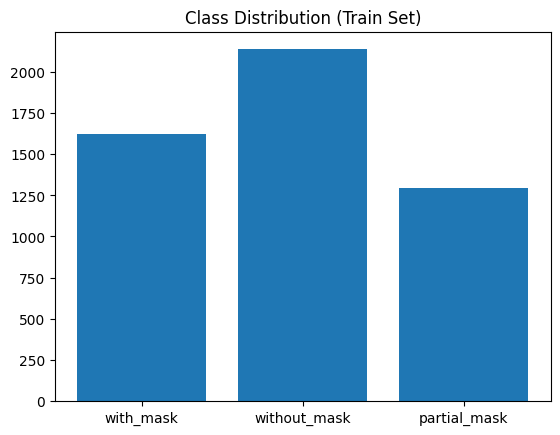

Sample unique shapes: {(320, 428), (864, 864), (278, 309), (327, 433), (493, 493), (285, 372), (226, 280), (273, 184), (351, 366), (374, 584), (320, 433), (259, 194), (503, 450), (160, 160), (257, 196), (228, 221), (296, 374), (414, 534), (1024, 1024), (467, 518), (353, 502), (275, 183), (301, 461)}


In [ ]:
# YOUR CODE HERE
import os
from PIL import Image
import matplotlib.pyplot as plt

base_dir = "/content/FaceMask_Dataset/MP2_FaceMask_Dataset/train"

# Count images & collect shapes
class_counts, shapes = {}, []
for cls in os.listdir(base_dir):
    files = os.listdir(os.path.join(base_dir, cls))
    class_counts[cls] = len(files)
    for f in files[:50]:
        with Image.open(os.path.join(base_dir, cls, f)) as img:
            shapes.append(img.size)

# Show class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Train Set)")
plt.show()

# Show shape distribution
print("Sample unique shapes:", set(shapes))


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [ ]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Train and validation
train_generator = train_datagen.flow_from_directory(
    "/content/FaceMask_Dataset/MP2_FaceMask_Dataset/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training")

validation_generator = train_datagen.flow_from_directory(
    "/content/FaceMask_Dataset/MP2_FaceMask_Dataset/test",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation")

# Test
test_generator = test_datagen.flow_from_directory(
    "/content/FaceMask_Dataset/MP2_FaceMask_Dataset/test",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False)


Found 4025 images belonging to 3 classes.
Found 250 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


### Visualize the sample images of each class using data generator

Hint: plt.subplot

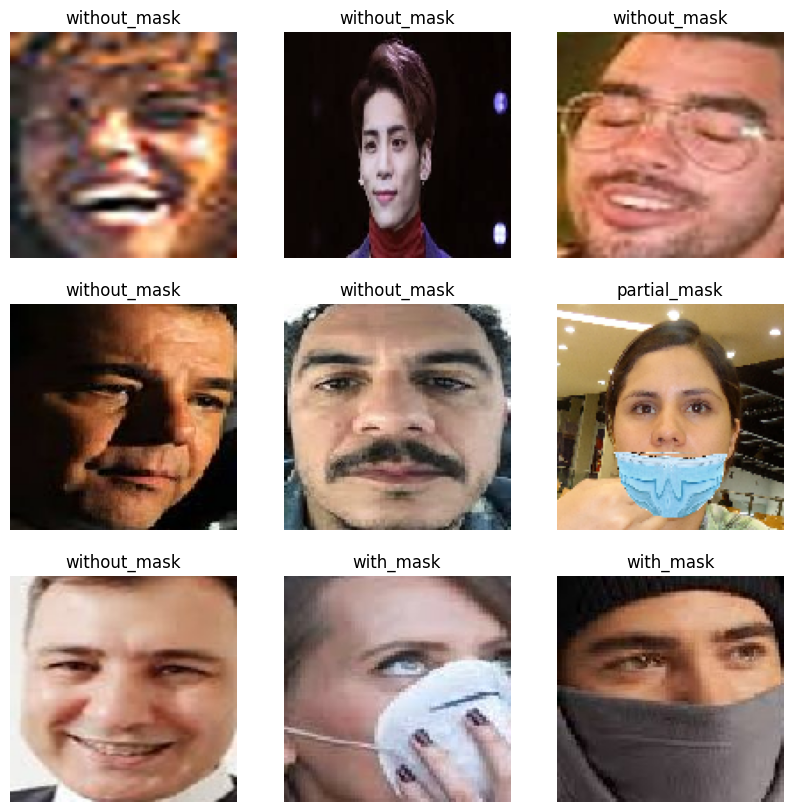

In [ ]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from generator
images, labels = next(train_generator)

# Plot first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(list(train_generator.class_indices.keys())[np.argmax(labels[i])])
    plt.axis("off")
plt.show()


## Build the CNN model using Keras (4 points)



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')   # 3 classes
])

# 2. Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show summary
model.summary()

# 3. Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# 4. Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 145ms/step - accuracy: 0.7523 - loss: 0.5832 - val_accuracy: 0.9160 - val_loss: 0.2651
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9506 - loss: 0.1492 - val_accuracy: 0.9440 - val_loss: 0.1636
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.9653 - loss: 0.1145 - val_accuracy: 0.9520 - val_loss: 0.1364
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9737 - loss: 0.0824 - val_accuracy: 0.9600 - val_loss: 0.1593
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.9790 - loss: 0.0715 - val_accuracy: 0.9360 - val_loss: 0.1954
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.9793 - loss: 0.0548 - val_accuracy: 0.9720 - val_loss: 0.1165
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.9871 - loss: 0.0424 - val_accuracy: 0.9560 - val_loss: 0.1650
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9883 - loss: 0.0369 - val

## Transfer learning (4 points)

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: More than 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

In [ ]:
# YOUR CODE HERE
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#Load pretrained model (without top layer)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))

# Freeze base model layers (to keep ImageNet features)
for layer in base_model.layers:
    layer.trainable = False

#Add fully connected layers for FaceMask classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)   # 3 classes

model = Model(inputs=base_model.input, outputs=output)

# 3. Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 4. Train (fine-tune top layers)
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

# 5. Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy with VGG16 Transfer Learning: {test_acc:.2f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 2,098,179 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.7910 - loss: 0.5119 - val_accuracy: 0.9600 - val_loss: 0.1130
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9725 - loss: 0.0841 - val_accuracy: 0.9760 - val_loss: 0.0828
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9808 - loss: 0.0541 - val_accuracy: 0.9840 - val_loss: 0.0587
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.9885 - loss: 0.0359 - val_accuracy: 0.9840 - val_loss: 0.0546
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.9933 - loss: 0.0295 - val_accuracy: 0.9840 - val_loss: 0.0530
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9887 - loss: 0.0355
Test Accuracy with VGG16 Transfer Learning: 0.99


### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

NotFoundError: Requested device not found


After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which the model accepts.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

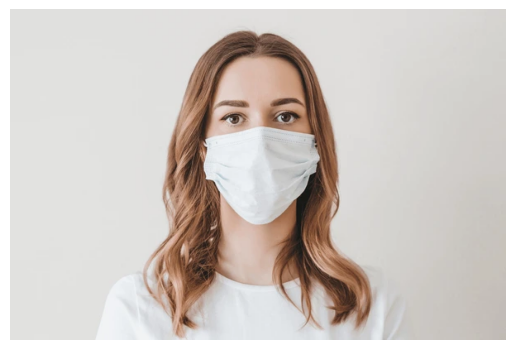

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: with_mask


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image

# Load and show image
features = Image.open("/portrait-young-girl-medical-mask-600nw-1683232735.webp")
plt.imshow(features)
plt.axis("off")
plt.show()

# Convert to numpy array and resize
img = features.resize((128,128))       # Resize to model input
x = image.img_to_array(img)

# Expand dimensions to 4D (batch of 1)
x = np.expand_dims(x, axis=0)

# Normalize (since model trained with rescale=1./255)
x = x / 255.0

# Predict using trained model
pred = model.predict(x)

# Map to class names
class_names = list(train_generator.class_indices.keys())
print("Predicted class:", class_names[np.argmax(pred)])



### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- What process was followed to tune the hyperparameters?
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- Discuss the confusion matrix in terms of the misclassifications

# Type report here

1.
The pre-trained model (e.g., VGG16) achieved higher accuracy than the custom CNN, as it leveraged pre-learned ImageNet features, while the CNN learned features from scratch and required more data to generalize.

2.
Hyperparameters such as learning rate, batch size, number of dense units, and dropout rate were tuned using validation performance, trial-and-error experiments, and observing convergence and overfitting trends.

3.
The pre-trained model detects masked, unmasked, and partially masked faces more accurately in live images due to its stronger feature extraction capability compared to the CNN trained from scratch.

4.
Misclassifications mainly occurred between unmasked and partially masked classes, as their facial coverage is visually similar, while masked faces were generally classified correctly.